In [1]:
import os
import time
import random
import numpy as np
from glob import glob
import cv2
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

from data import *
# from data_aug import *
from utils import *

from loss import *
from modifynet import *
from model import *
from unet import *

from metrics import *
from visualize import *

In [ ]:
path = "./Kvasir-SEG"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

create_dir("./new_data/train/image/")
create_dir("./new_data/train/mask/")
create_dir("./new_data/valid/image/")
create_dir("./new_data/valid/mask/")
create_dir("./new_data/test/image/")
create_dir("./new_data/test/mask/")

augment_data(train_x, train_y, "./new_data/train/", augment=True)
augment_data(valid_x, valid_y, "./new_data/valid/", augment=False)
augment_data(test_x, test_y, "./new_data/test/", augment=False)

In [2]:
train_x = sorted(glob("./new_data/train/image/*"))[:]
train_y = sorted(glob("./new_data/train/mask/*"))[:]
valid_x = sorted(glob("./new_data/valid/image/*"))[:]
valid_y = sorted(glob("./new_data/valid/mask/*"))[:]
test_x = sorted(glob("./new_data/test/image/*"))[:]
test_y = sorted(glob("./new_data/test/mask/*"))[:]
train_x, train_y = shuffling(train_x, train_y)

size = (256, 256)
batch_size = 1
num_epochs = 30
lr = 1e-4
checkpoint_path = "./checkpoint_model.pth"
# checkpoint_path = "./checkpoint_unet.pth"

""" KvasirDataset """
train_dataset = PolypDataset(train_x[:], train_y[:], size)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

valid_dataset = PolypDataset(valid_x, valid_y, size)
valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

test_dataset = PolypDataset(test_x + valid_x, test_y + valid_y, size)
test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

In [3]:
""" ETIS-LaribPolypDB """
test_x2 = sorted(glob("./ETIS-LaribPolypDB/ETIS-LaribPolypDB/*"))[:]
test_y2 = sorted(glob("./ETIS-LaribPolypDB/Ground Truth/*"))[:]
test_dataset2 = PolypDataset(test_x2 , test_y2 , size)
test_loader2 = DataLoader(
    dataset = test_dataset2,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

In [4]:
device = torch.device('cuda')
#model = UNet()
model = Net()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0

    model.train()
    for i, (x, y) in tqdm(enumerate(loader), total = len(loader)):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        p = model(x)

        loss = loss_fn(p, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    model.eval()
    with torch.no_grad():
        for i, (x, y) in tqdm(enumerate(loader), total = len(loader)):
            x = x.to(device)
            y = y.to(device)
            p = model(x)
            
            loss = loss_fn(p, y)
            score = calc_evaluate(p.cpu(), y.cpu())
            metrics_score = [metrics_score[i]+score[i] for i in range(min(len(metrics_score),len(score)))]
            epoch_loss += loss.item()
    
    scores = [round((s / len(test_loader)), 5) for s in metrics_score]
    print(scores)
    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:
#model.load_state_dict(torch.load(checkpoint_path, map_location=device))
print(num_epochs)
best_valid_loss = 0.3
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)
        print("save")

    data_str = f'\tEpoch：{epoch} Train Loss: {train_loss:.3f} Valid Loss: {valid_loss: .3f}\n'
    print(data_str)

UNet: [0.77699, 0.86454, 0.68558, 0.78199, 0.81402, 0.93853]
fps: 12.960833109184957
param count of UNet:29.594178199768066 M
ModifyNet: [0.88405, 0.8522, 0.76268, 0.84039, 0.842, 0.95355]
fps: 6.632617428649598
param count of ModifyNet:13.638367652893066 M


<Figure size 1440x1440 with 0 Axes>

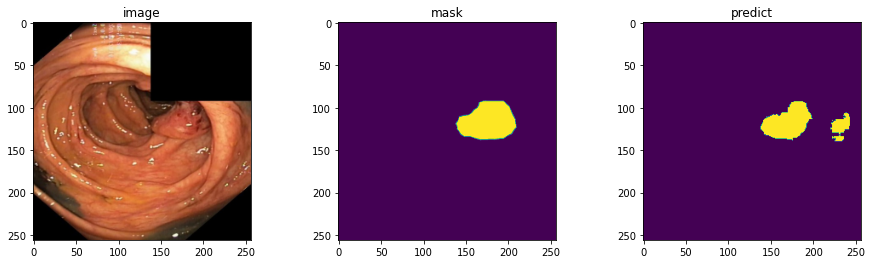

<Figure size 1440x1440 with 0 Axes>

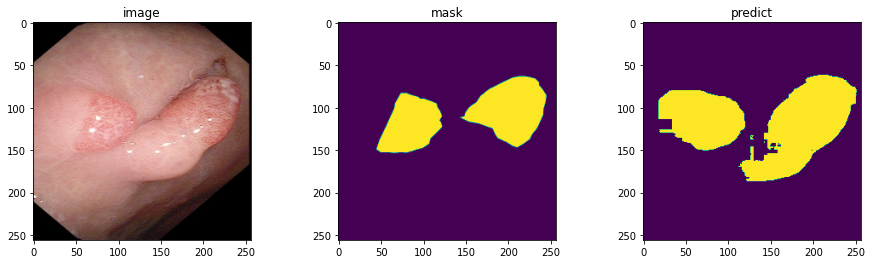

<Figure size 1440x1440 with 0 Axes>

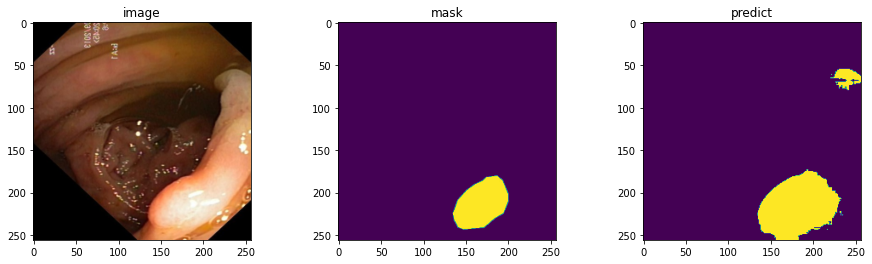

<Figure size 1440x1440 with 0 Axes>

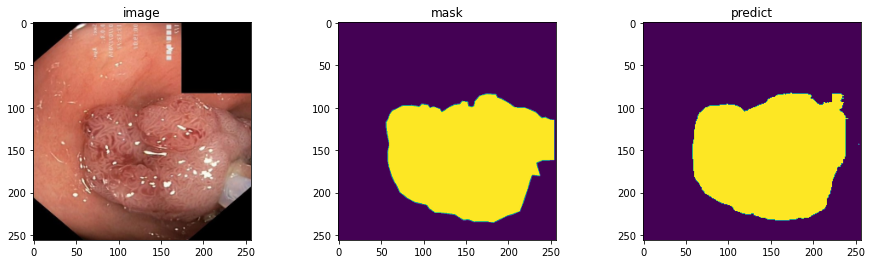

<Figure size 1440x1440 with 0 Axes>

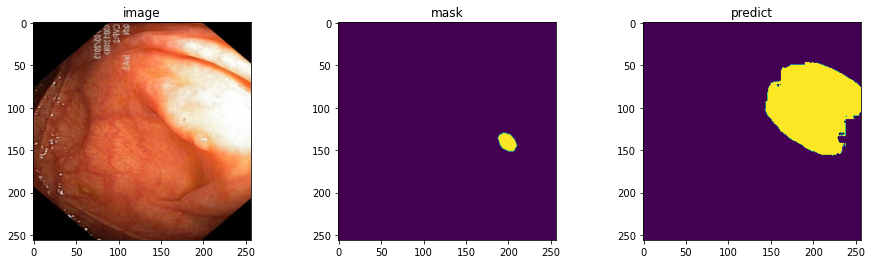

<Figure size 1440x1440 with 0 Axes>

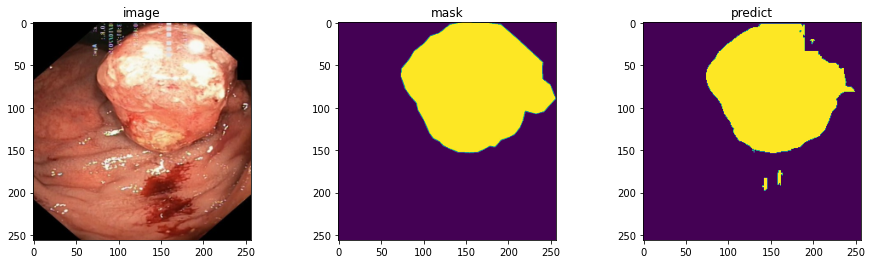

<Figure size 1440x1440 with 0 Axes>

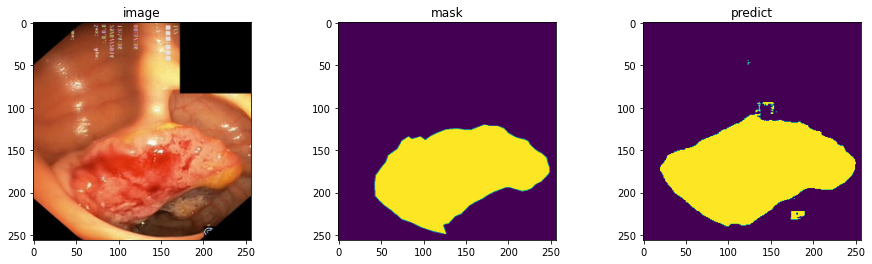

<Figure size 1440x1440 with 0 Axes>

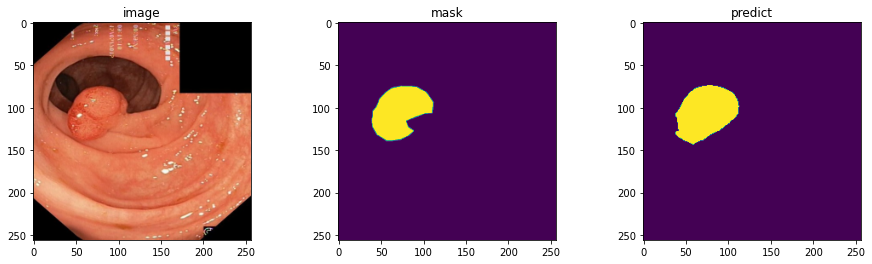

<Figure size 1440x1440 with 0 Axes>

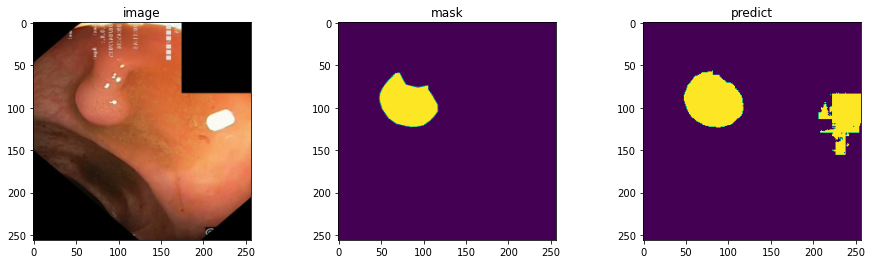

<Figure size 1440x1440 with 0 Axes>

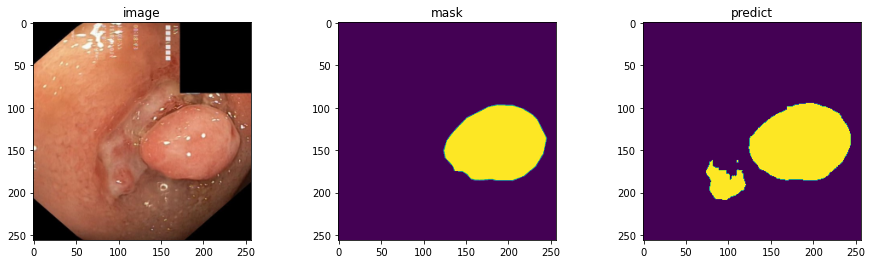

<Figure size 1440x1440 with 0 Axes>

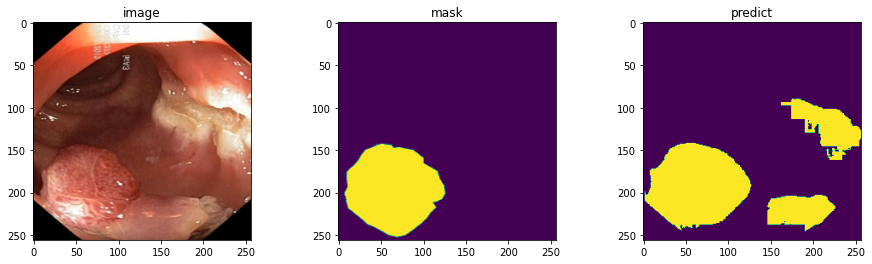

<Figure size 1440x1440 with 0 Axes>

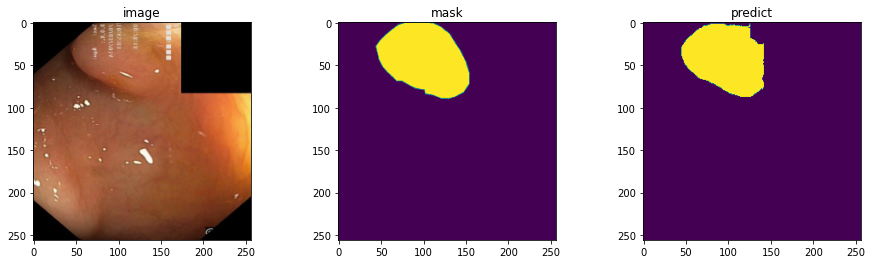

<Figure size 1440x1440 with 0 Axes>

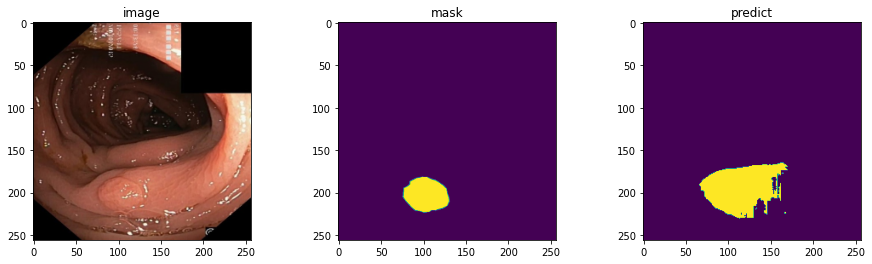

<Figure size 1440x1440 with 0 Axes>

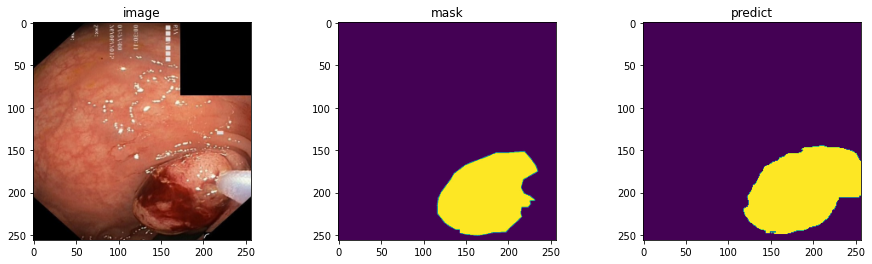

<Figure size 1440x1440 with 0 Axes>

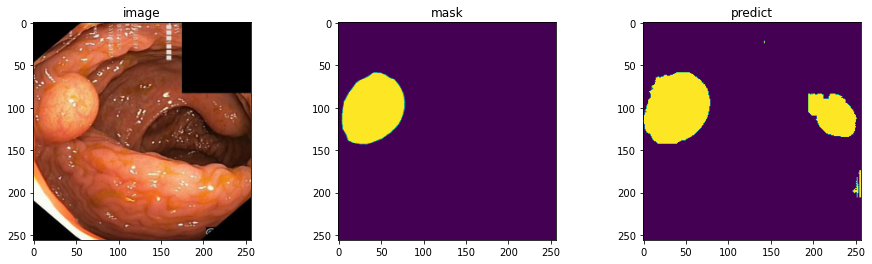

<Figure size 1440x1440 with 0 Axes>

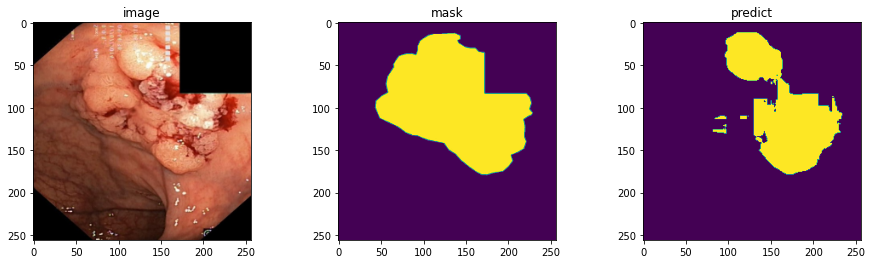

<Figure size 1440x1440 with 0 Axes>

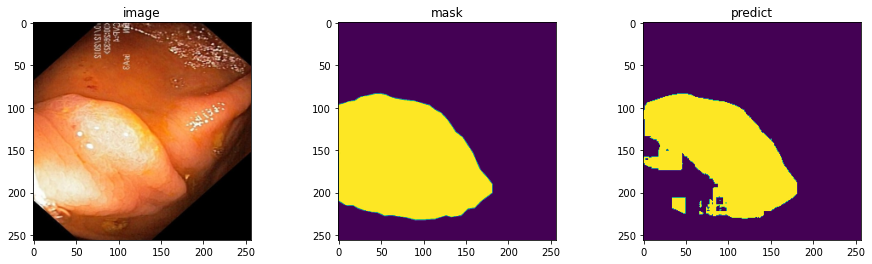

<Figure size 1440x1440 with 0 Axes>

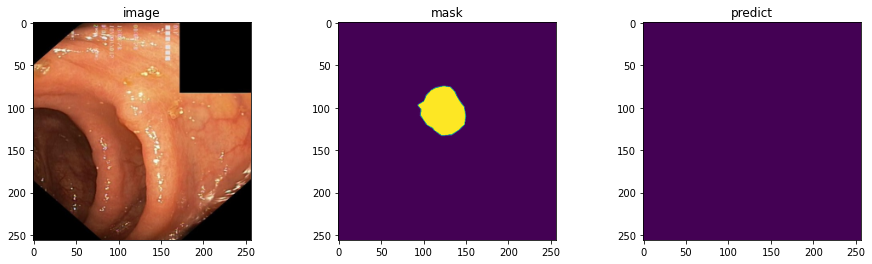

<Figure size 1440x1440 with 0 Axes>

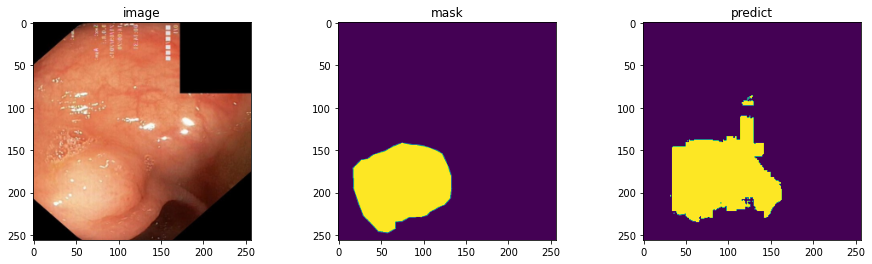

<Figure size 1440x1440 with 0 Axes>

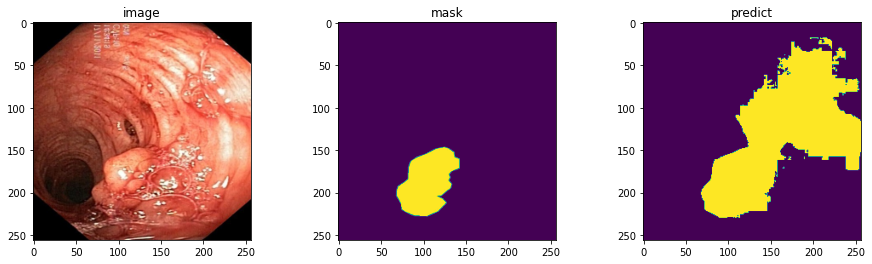

<Figure size 1440x1440 with 0 Axes>

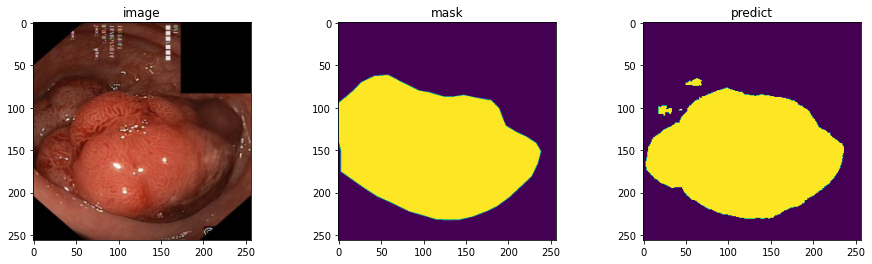

<Figure size 1440x1440 with 0 Axes>

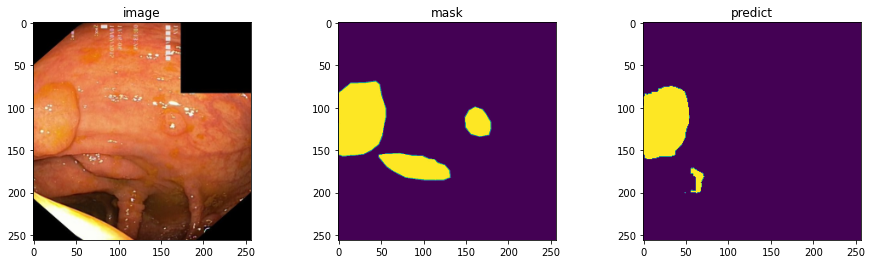

<Figure size 1440x1440 with 0 Axes>

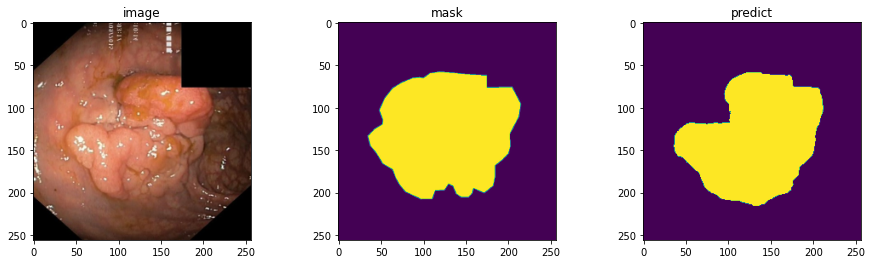

<Figure size 1440x1440 with 0 Axes>

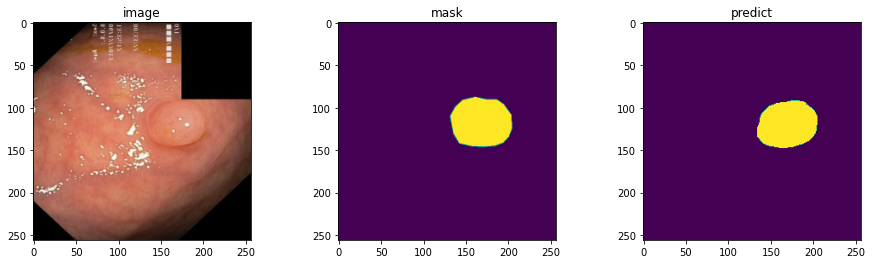

<Figure size 1440x1440 with 0 Axes>

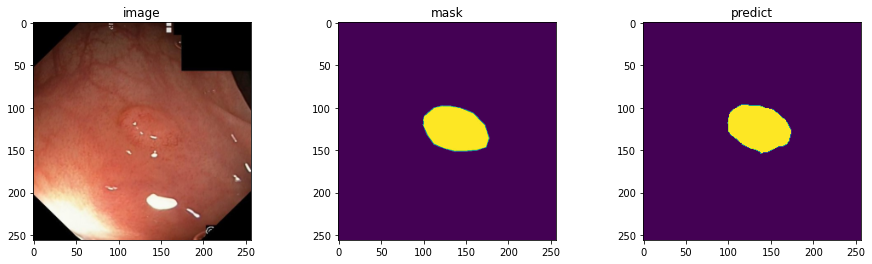

<Figure size 1440x1440 with 0 Axes>

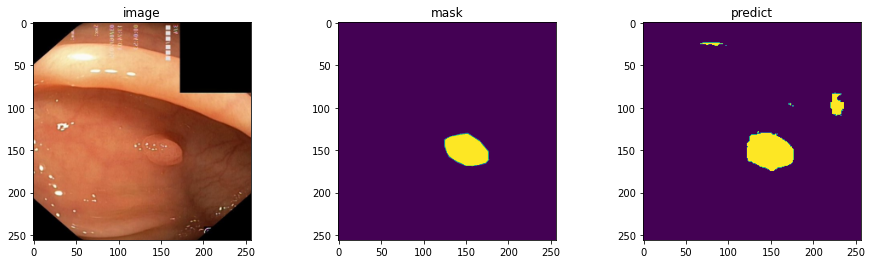

<Figure size 1440x1440 with 0 Axes>

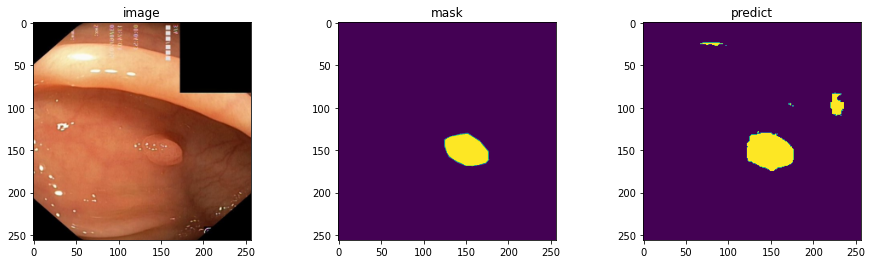

<Figure size 1440x1440 with 0 Axes>

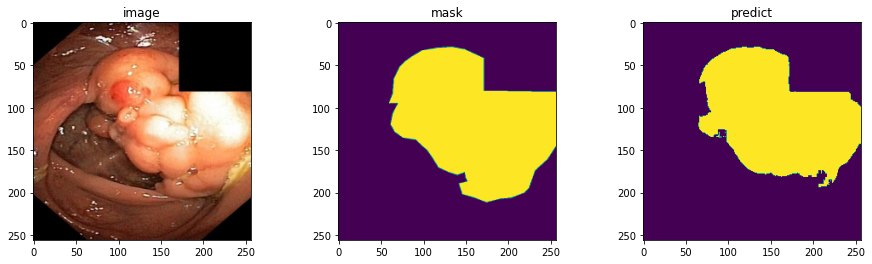

<Figure size 1440x1440 with 0 Axes>

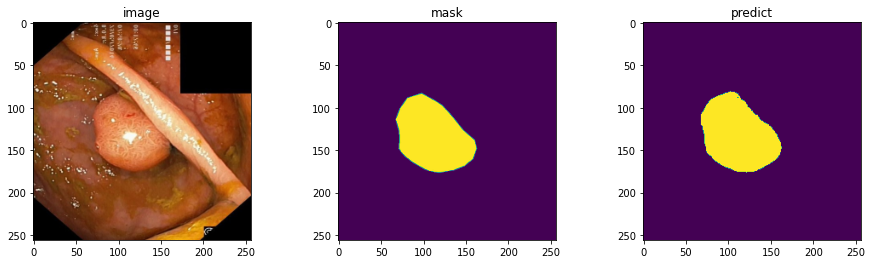

<Figure size 1440x1440 with 0 Axes>

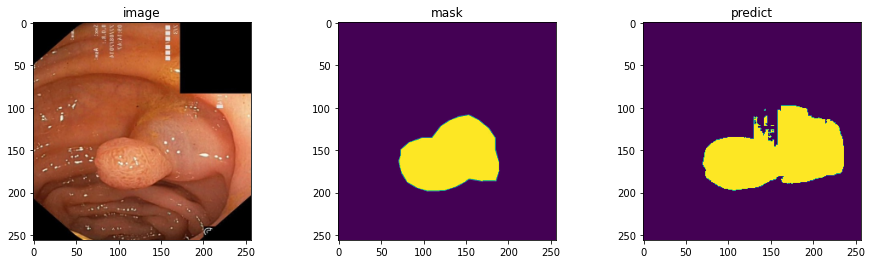

<Figure size 1440x1440 with 0 Axes>

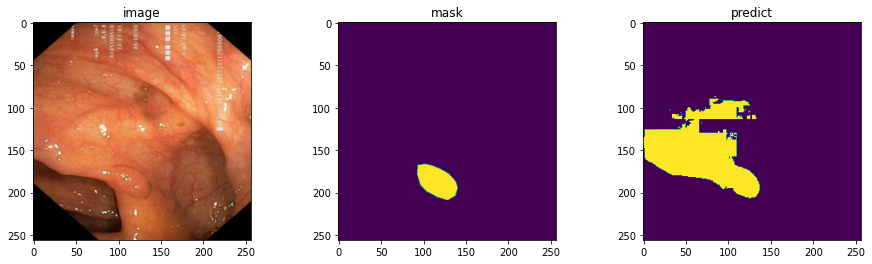

<Figure size 1440x1440 with 0 Axes>

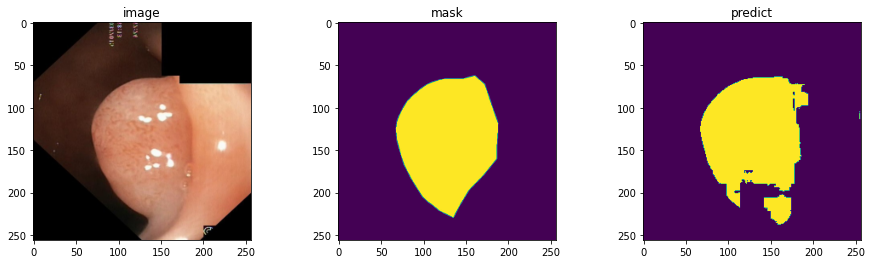

<Figure size 1440x1440 with 0 Axes>

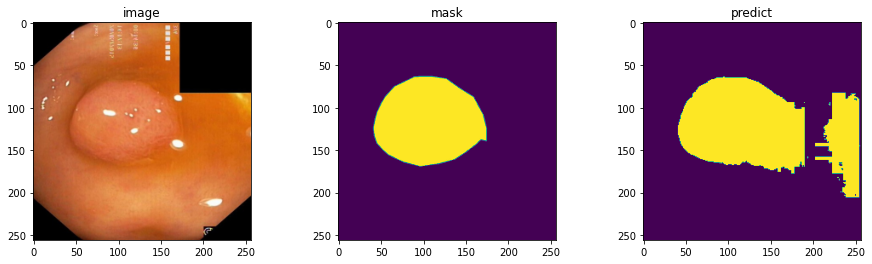

<Figure size 1440x1440 with 0 Axes>

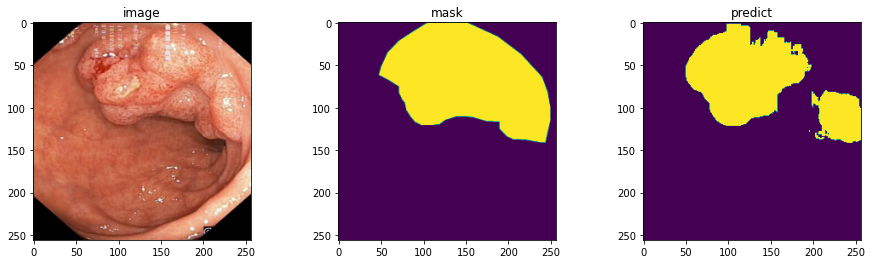

<Figure size 1440x1440 with 0 Axes>

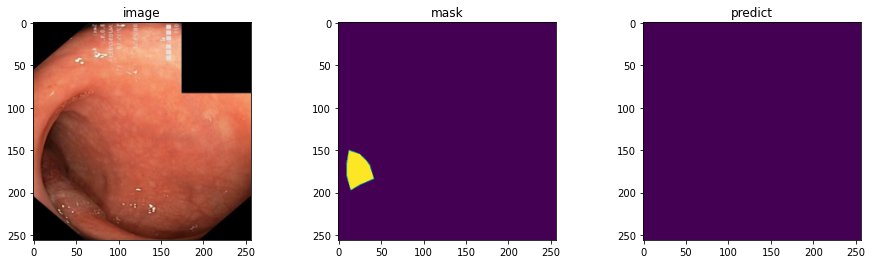

<Figure size 1440x1440 with 0 Axes>

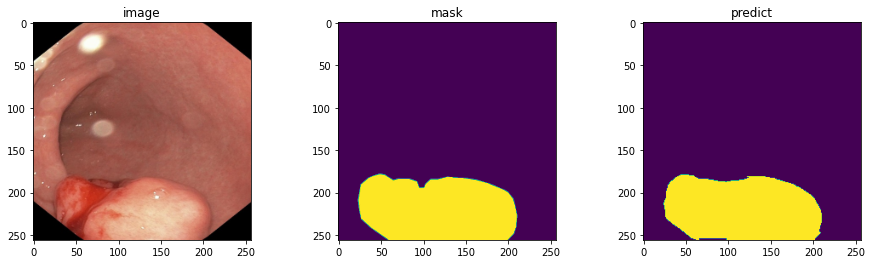

<Figure size 1440x1440 with 0 Axes>

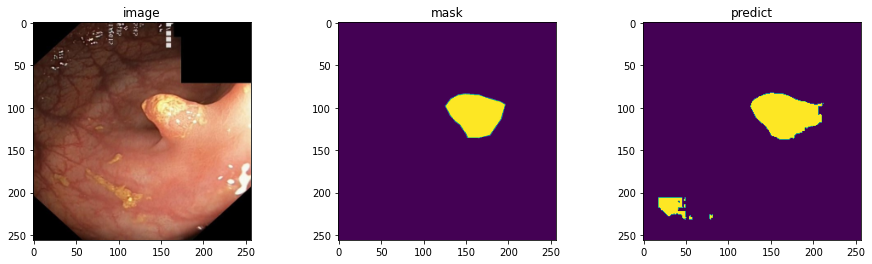

<Figure size 1440x1440 with 0 Axes>

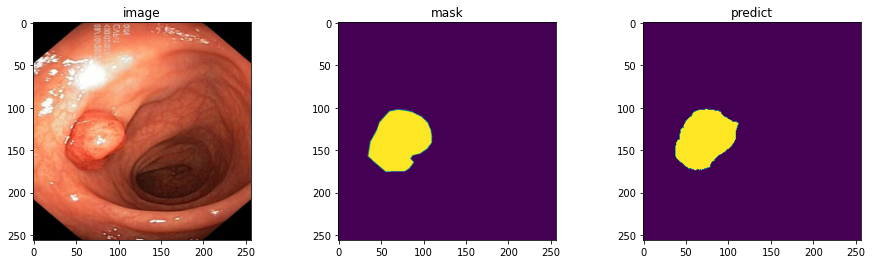

<Figure size 1440x1440 with 0 Axes>

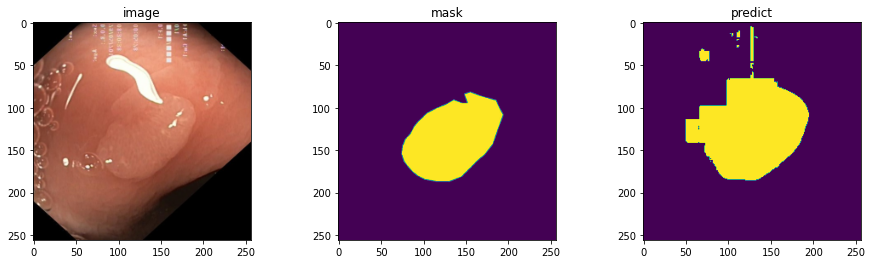

<Figure size 1440x1440 with 0 Axes>

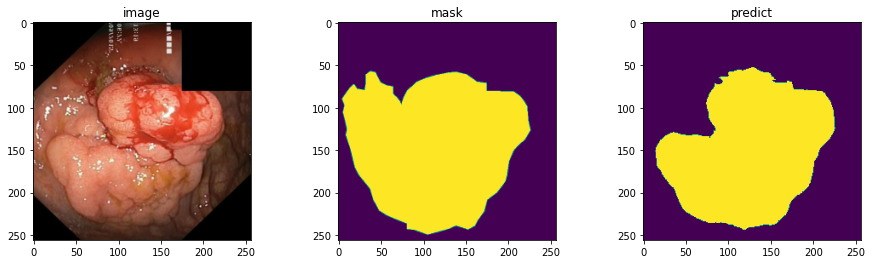

<Figure size 1440x1440 with 0 Axes>

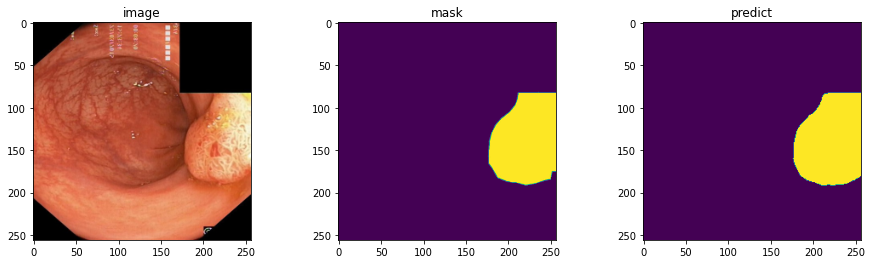

<Figure size 1440x1440 with 0 Axes>

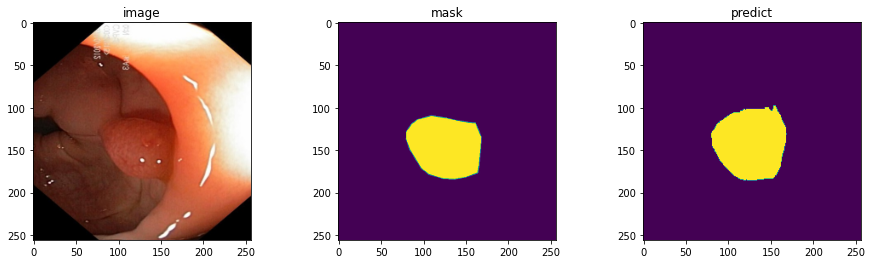

<Figure size 1440x1440 with 0 Axes>

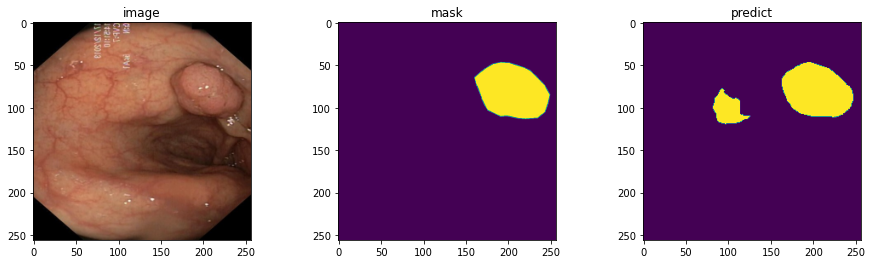

<Figure size 1440x1440 with 0 Axes>

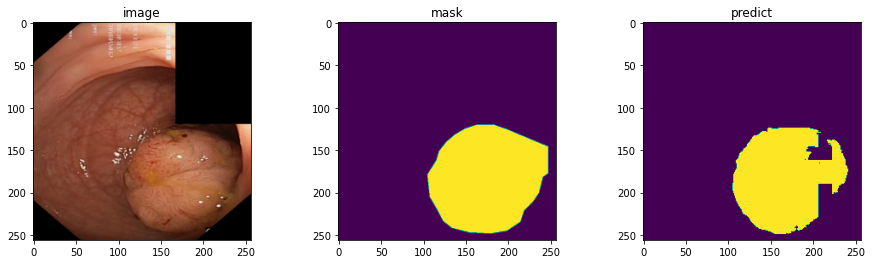

<Figure size 1440x1440 with 0 Axes>

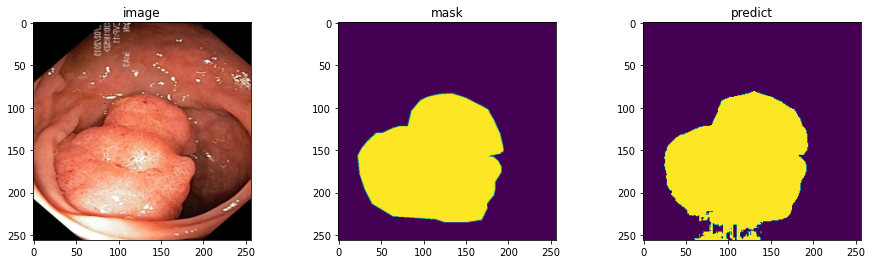

<Figure size 1440x1440 with 0 Axes>

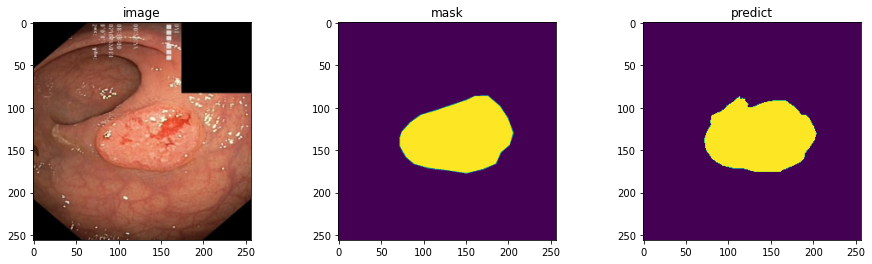

<Figure size 1440x1440 with 0 Axes>

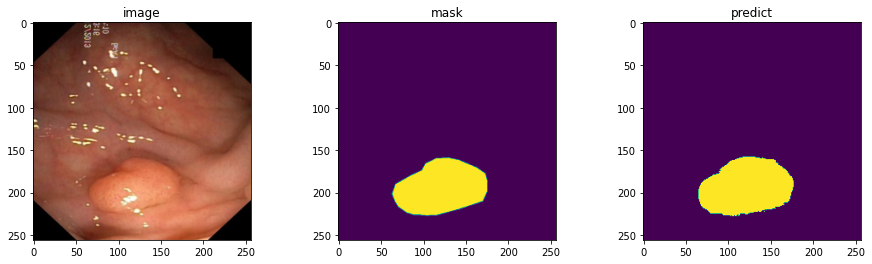

<Figure size 1440x1440 with 0 Axes>

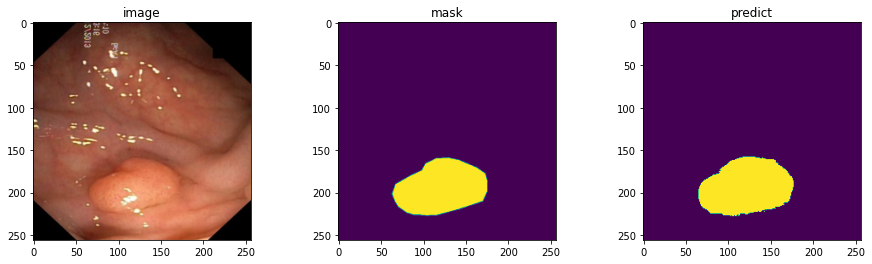

<Figure size 1440x1440 with 0 Axes>

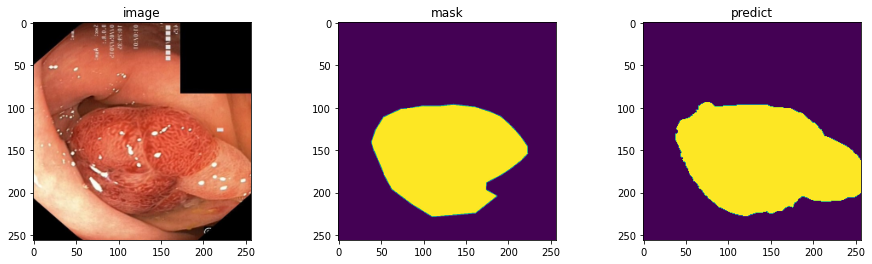

<Figure size 1440x1440 with 0 Axes>

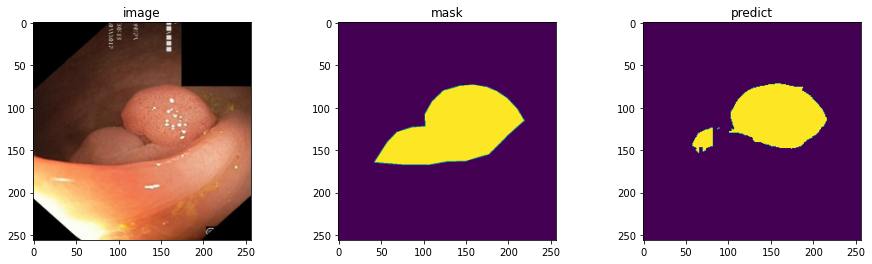

In [4]:
cps = ["./checkpoint_unet.pth", "./checkpoint_modifynet.pth"]
models = [UNet(), ModifyNet()]
modelnames = ["UNet", "ModifyNet"]

for cp, model, modelname in zip(cps, models, modelnames):
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    device = torch.device('cuda')
    model = model.to(device)
    model.load_state_dict(torch.load(cp, map_location=device))
    model.eval()
    start = time.time()
    
    # exclude extreme cases in the experiment
    count = 0
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        with torch.no_grad():
            p = model(x)
            score = calc_evaluate(p.cpu(), y.cpu())
            if modelname == "UNet":
                if i < 50:
                    show_image(x, y, p)
            if score[0] >= 1:
                count += 1
            else:
                metrics_score = [metrics_score[i]+score[i] for i in range(min(len(metrics_score),len(score)))]
    
    end = time.time()
    # precision, recall, iou, f1, f2, accuracy_total
    scores = [round((s / (len(test_loader)-count)), 5) for s in metrics_score]
    print(f"{modelname}: {scores}")
    print(f"fps: {len(test_loader)/(end - start)}")
    s = count_param(model)
    print(f"param count of {modelname}:{s} M")